In [1]:
import datetime
import pandas as pd
import numpy as np

data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data['StartDate'] = pd.to_datetime(data['StartDate'])
data['EndDate'] = pd.to_datetime(data['EndDate'])

from IPython.display import display, HTML

display(HTML('<center><h1>Predicting Tickets and Team Size using Real Data and MLP</h1></center></br/>'))

display(HTML('<h1>Raw Data</h1></br/>'))

table = '<table>' \
            '<tr>' \
                '<td style="text-align: left">Tickets</td>' \
                '<td style="text-align: left">clientes reais</td>' \
            '</tr>' \
            '<tr>' \
                '<td style="text-align: left">TicketsPrev</td>' \
                '<td style="text-align: left">clientes estimados</td>' \
            '</tr>' \
            '<tr>' \
                '<td style="text-align: left">Persons</td>' \
                '<td style="text-align: left">pessoas em caixa estimadas a partir de TicketsPrev</td>' \
            '</tr>' \
            '<tr>' \
                '<td style="text-align: left">Articles</td>' \
                '<td style="text-align: left">artigos vendidos reais</td>' \
            '</tr>' \
            '<tr>' \
                '<td style="text-align: left">ArticlesPrev</td>' \
                '<td style="text-align: left">artigos vendidos estimados</td>' \
            '</tr>' \
            '<tr>' \
                '<td style="text-align: left">Checkouts</td>' \
                '<td style="text-align: left">caixas que venderam artigos</td>' \
            '</tr>' \
        '</table>'

display(HTML(table))

data

Tickets,clientes reais
TicketsPrev,clientes estimados
Persons,pessoas em caixa estimadas a partir de TicketsPrev
Articles,artigos vendidos reais
ArticlesPrev,artigos vendidos estimados
Checkouts,caixas que venderam artigos


,RosterCode,Date,StartDate,EndDate,Tickets,TicketsPrev,Persons,Articles,ArticlesPrev,Checkouts
0,10,2021-11-01,2021-11-01 09:00:00,2021-11-01 10:00:00,32,55,2,77,309,1
1,10,2021-11-01,2021-11-01 10:00:00,2021-11-01 11:00:00,57,69,3,121,440,1
2,10,2021-11-01,2021-11-01 11:00:00,2021-11-01 12:00:00,87,112,4,175,643,1
3,10,2021-11-01,2021-11-01 12:00:00,2021-11-01 13:00:00,97,118,4,186,643,1
4,10,2021-11-01,2021-11-01 13:00:00,2021-11-01 14:00:00,100,130,4,194,791,1
...,...,...,...,...,...,...,...,...,...,...
207478,75,2022-10-31,2022-10-31 17:00:00,2022-10-31 18:00:00,52,38,2,272,189,3
207479,75,2022-10-31,2022-10-31 18:00:00,2022-10-31 19:00:00,122,66,3,727,462,4
207480,75,2022-10-31,2022-10-31 19:00:00,2022-10-31 20:00:00,125,92,3,703,453,4
207481,75,2022-10-31,2022-10-31 20:00:00,2022-10-31 21:00:00,114,70,3,658,368,4


In [2]:
data_filtered = data.drop(columns=['Date', 'EndDate' , 'Articles', 'ArticlesPrev'])
display(HTML('<h1>Initial Data Filter</h1>'))
data_filtered

,RosterCode,StartDate,Tickets,TicketsPrev,Persons,Checkouts
0,10,2021-11-01 09:00:00,32,55,2,1
1,10,2021-11-01 10:00:00,57,69,3,1
2,10,2021-11-01 11:00:00,87,112,4,1
3,10,2021-11-01 12:00:00,97,118,4,1
4,10,2021-11-01 13:00:00,100,130,4,1
...,...,...,...,...,...,...
207478,75,2022-10-31 17:00:00,52,38,2,3
207479,75,2022-10-31 18:00:00,122,66,3,4
207480,75,2022-10-31 19:00:00,125,92,3,4
207481,75,2022-10-31 20:00:00,114,70,3,4


In [7]:
display(HTML('<h1>Auxiliary Functions</h1>'))

def model_metrics(y_true, y_pred):
    d_metrics = {}
    d_metrics['mse'] = np.sqrt(mean_squared_error(y_true, y_pred))
    d_metrics['mae'] = mean_absolute_error(y_true, y_pred)
    d_metrics['r2_score'] = r2_score(y_true, y_pred)
    
    return d_metrics

def streming_outlier_detection(ts, k, s, alpha):
    ts_copy = np.copy(ts)
    outliers = []

    prev_elements = np.ones(k)

    for i in range(k*s,len(ts)):
        for j in range(k):
            prev_elements[j]=ts[i-(j+1)*s]
            
        mu=np.mean(prev_elements)
        sigma=np.std(prev_elements)
        
        upper_whisker=mu+alpha*sigma
        lower_whisker=mu-alpha*sigma
        
        if ts[i]>upper_whisker or ts[i]<lower_whisker:
            outliers.append([i,ts[i]])
            masked=np.ma.masked_equal(prev_elements, 0)
            ts_copy[i]=np.where(masked.mean()==None, 0, masked.mean())
            
    return outliers, ts_copy

def to_supervised(y1, y2, n_lags: int, n_output: int = 1):
    N = len(y1)

    n_rows = N - n_lags - n_output + 1
    
    X = np.zeros((n_rows, n_lags*2))
    y = np.zeros((n_rows, n_output*2))
    
    for i in range(N - n_lags):
        if i + n_lags + n_output > N:
            break

        #aux = np.zeros(n_lags*2)
        aux = []

        for j in range(i, i + n_lags, 1):
            #aux[j - i] = y1[j]
            aux += [y1[j]]
            aux += [y2[j]]

        X[i,:] = aux
        
        aux = []

        for j in range(i + n_lags, i + n_lags + n_output, 1):
            aux += [y1[j]]
            aux += [y2[j]]
        
        y[i,:] = aux
        #y[i,:] = timeseries[i + n_lags : i + n_lags + n_output]

    return X, y

def pre_process_data(data):
    data['ds'] = pd.to_datetime(data['ds'])
    data.shape

    data_resample = pd.DataFrame(data.resample('H', on = 'ds').sum())
    data_resample.reset_index(inplace=True)

    return data_resample

class PrintTable:
    def __init__(self, values, captions, widths, aligns):
        if not all([len(values[0]) == len(x) for x in [captions, widths, aligns]]):
            raise Exception()

        self._tablewidth = sum(widths) + 3*(len(captions)-1) + 4
        self._values = values
        self._captions = captions
        self._widths = widths
        self._aligns = aligns

    def print(self):
        self._printTable()

    def _printTable(self):
        formattext_head = ""
        formattext_cell = ""
        
        for i, v in enumerate(self._widths):
            formattext_head += "{" + str(i) + ":^" + str(v) + "} | "
            formattext_cell += "{" + str(i) + ":" + self._aligns[i] + str(v) + "} | "
            
        formattext_head = formattext_head[:-3]
        formattext_head = "  " + formattext_head.strip() + "  "
        formattext_cell = formattext_cell[:-3]
        formattext_cell = "  " + formattext_cell.strip() + "  "

        print("-"*self._tablewidth)
        print(formattext_head.format(*self._captions))
        print("-"*self._tablewidth)
        
        for w in self._values:
            print(formattext_cell.format(*w))
            
        print("-"*self._tablewidth)


----------------------------------------------------------------------------------------------------------------
Store 10
----------------------------------------------------------------------------------------------------------------
< 1: real: 4  estimated: 2
< 1: real: 3  estimated: 1
< 1: real: 4  estimated: 2
< 1: real: 4  estimated: 2
< 1: real: 4  estimated: 2
< 1: real: 4  estimated: 1
< 1: real: 4  estimated: 2
< 1: real: 4  estimated: 2
< 1: real: 4  estimated: 2
< 1: real: 4  estimated: 2
< 1: real: 4  estimated: 2
> 1: real: 2  estimated: 4
> 1: real: 1  estimated: 3
> 1: real: 1  estimated: 4
> 1: real: 1  estimated: 4
> 1: real: 1  estimated: 4
> 1: real: 1  estimated: 4
> 1: real: 1  estimated: 4
< 1: real: 4  estimated: 2
< 1: real: 4  estimated: 2
< 1: real: 4  estimated: 2
< 1: real: 4  estimated: 2
< 1: real: 4  estimated: 2
< 1: real: 3  estimated: 1
< 1: real: 3  estimated: 1
< 1: real: 4  estimated: 2
> 1: real: 2  estimated: 4
< 1: real: 4  estimated: 2
> 1: rea

{'mse': 0.6586059283030474, 'mae': 0.3323415678046773, 'r2_score': 0.8623483443549915}


{'mse': 0.5283622494715786, 'mae': 0.20694444444444443, 'r2_score': 0.9114081585054473}


1.6059458310024675


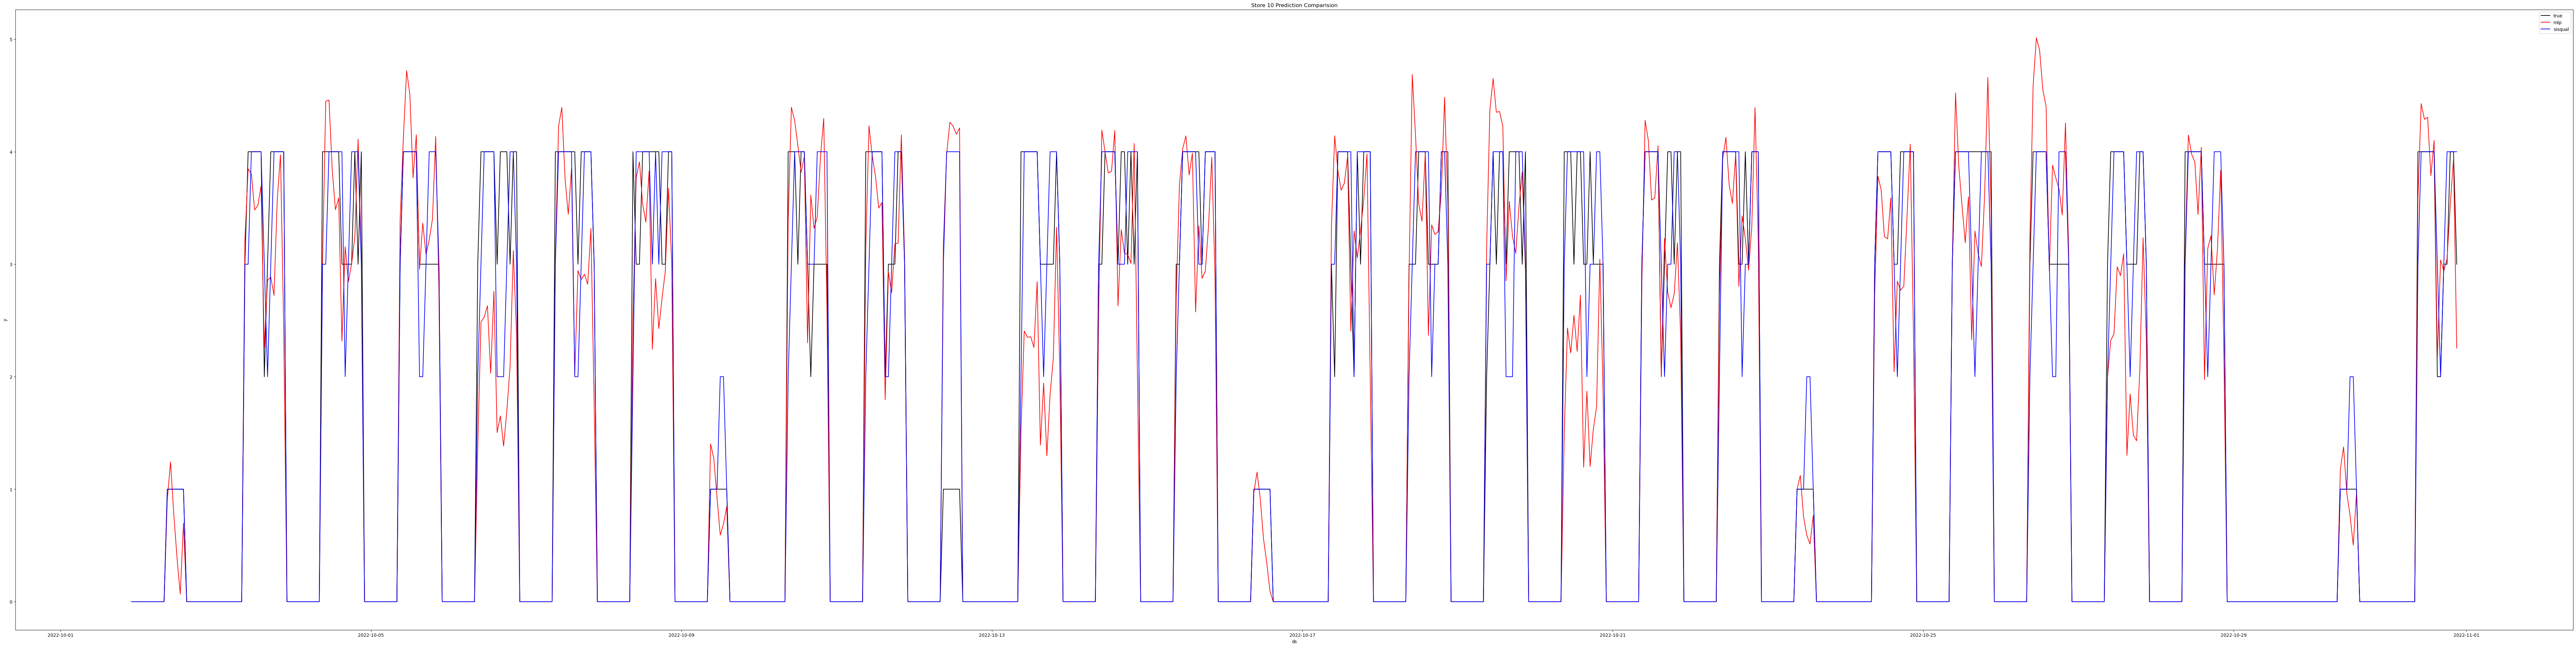

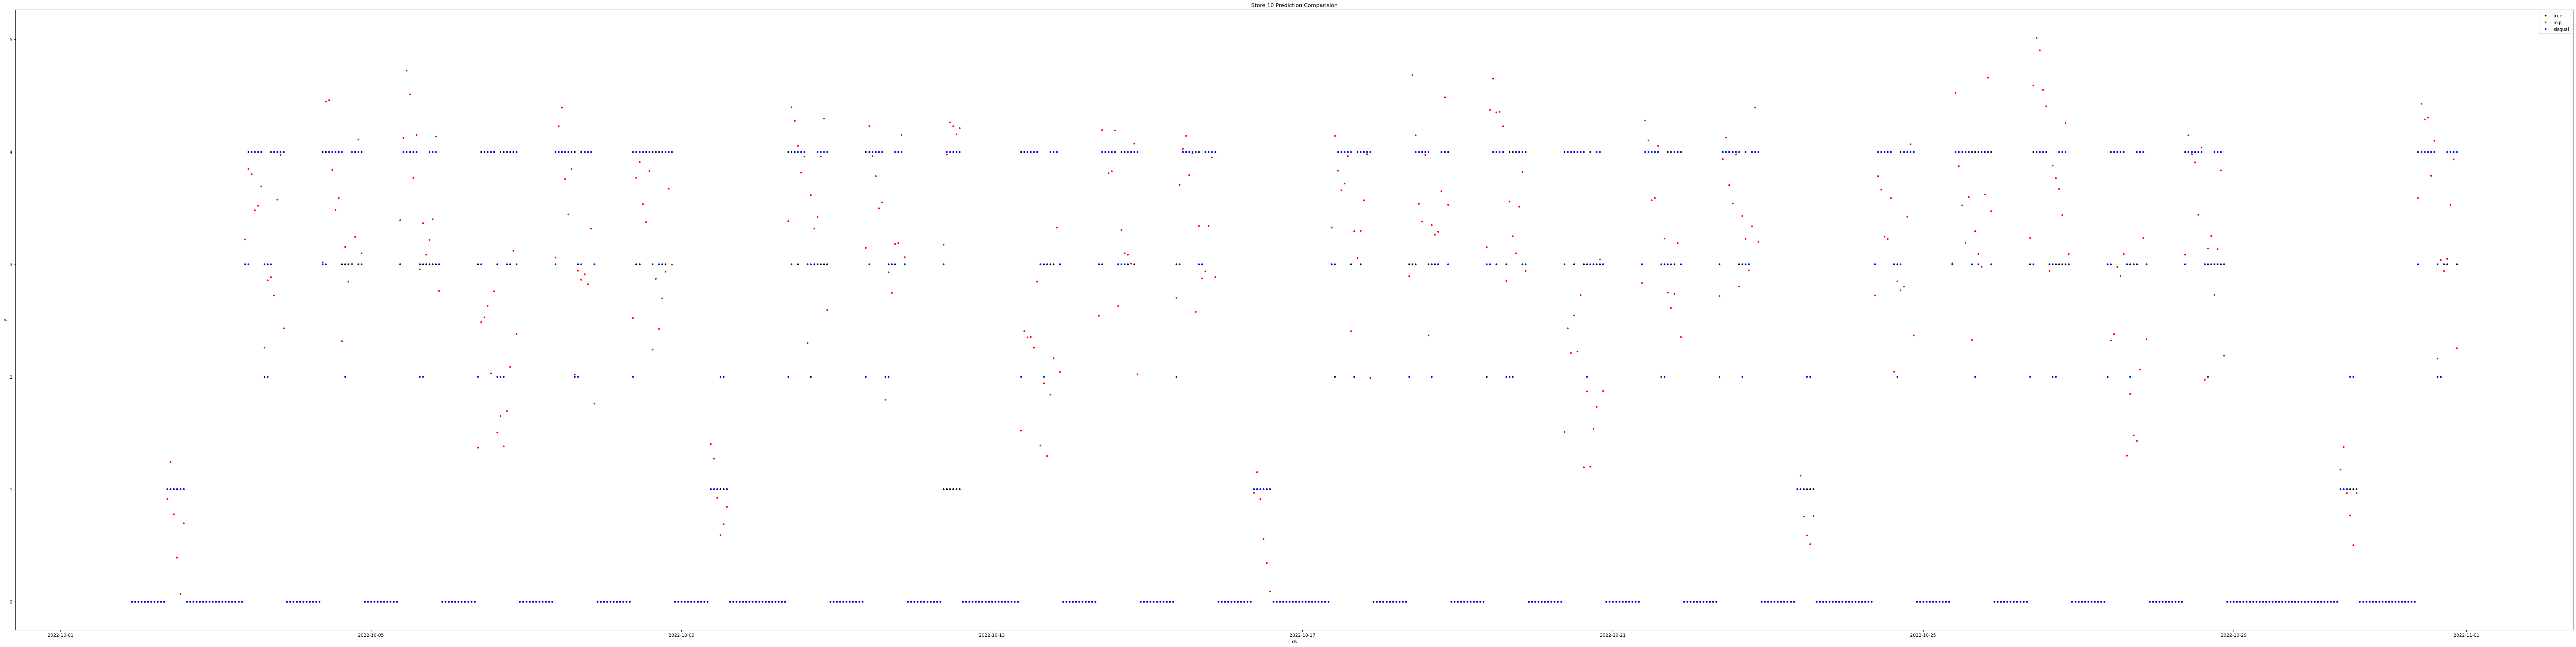

In [ ]:
stores = pd.value_counts(data_filtered['RosterCode'].values.ravel())
stores_ids = list(stores.index)
stores_ids.sort()

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib import pyplot
from datetime import datetime, timedelta
from math import sqrt, ceil, floor

#from pmdarima.arima import ADFTest
#from statsmodels.tsa.seasonal import seasonal_decompose 
#from statsmodels.tsa.stattools import adfuller
#import seaborn as sns
#pyplot.style.use('dark_background')

#from mlxtend.frequent_patterns import association_rules

DEBUG = False
SHOW_RAW = False
SHOW_LINE_CHART = True
SHOW_POINT_CHART = True
SHOW_BAR_CHART = True

if DEBUG:
    display(HTML('<h3>Stores Ids</h3>'))
    print(stores_ids)
    print('')
    print('Nº stores: ' + str(len(stores_ids)))

d = {  'Store ID': []
     , 'Mlp MAE': []
     , 'Mlp MSE': []
     , 'Mlp R2': []
     , 'Sisq MAE': []
     , 'Sisq MSE': []
     , 'Sisq R2': []
     , 'RelMAE Mlp/Sisq': []}

stats = pd.DataFrame(data=d)

d = {  'ROUND =': []
     , 'ROUND +1': []
     , 'ROUND -1': []
     , 'ROUND > 1': []
     , 'ROUND < 1': []
     , 'FLOOR =': []
     , 'FLOOR +1': []
     , 'FLOOR -1': []
     , 'FLOOR > 1': []
     , 'FLOOR < 1': []     
     , 'CEIL =': []
     , 'CEIL +1': []
     , 'CEIL -1': []
     , 'CEIL > 1': []
     , 'CEIL < 1': []}
    
acc = pd.DataFrame(data=d)

d = {  'Store ID': []
     , 'N Hours': []
     , 'N Hours Agg': []
     , 'N Hours Train': []
     , 'N Hours Test': []
     , 'RAW MAE': []
     , 'ROUND MAE': []
     , 'FLOOR MAE': []
     , 'CEIL MAE': []}

mae = pd.DataFrame(data=d)

j = 0
for id in stores_ids:
    store_data = data_filtered.loc[data_filtered['RosterCode'] == id]
    store_data = store_data.drop(columns=['RosterCode'])

    n_hours = store_data.shape[0]
    
    print('')
    print('----------------------------------------------------------------------------------------------------------------')
    print('Store ' + str(id))
    print('----------------------------------------------------------------------------------------------------------------')

    if DEBUG:
        display(HTML('<h3>Store Data</h3>'))
        print(store_data)
    
    #----------------------------------------------------------------------------------------------------------------

    #store_data.rename(columns={"StartDate": "ds", "Checkouts": "y", 'Persons': 'sisq'}, inplace=True)
    store_data.rename(columns={  "StartDate": "ds"
                               , "Tickets": "y1"
                               , 'TicketsPrev': 'sisq_1'
                               , "Checkouts": "y2"
                               , 'Persons': 'sisq_2'}, inplace=True)
    
    #----------------------------------------------------------------------------------------------------------------
    
    if DEBUG:
        display(HTML('<h3>Store Data Renamed</h3>'))
        print(store_data)
    
    #----------------------------------------------------------------------------------------------------------------
    
    store_data = pre_process_data(store_data)
    
    n_hours_agg = store_data.shape[0]
    
    if DEBUG:
        display(HTML('<h3>Store Data Aggregated</h3>'))
        print(store_data)
    
    #----------------------------------------------------------------------------------------------------------------
    
    K = 53       # last k seasonal elements for comparison
    S = 168      # seasonality period
    ALPHA = 2    # standard deviation multiplication factor
    
    MAX_N_ITERATIONS = 1000
    
    n_lags = 720
    forecast_period = 720

    #----------------------------------------------------------------------------------------------------------------

    train_data = store_data[:-forecast_period].copy()
    test_data = store_data[-forecast_period:].copy()
    
    n_hours_train = train_data.shape[0]
    n_hours_test = test_data.shape[0]
    
    train_data.drop(columns=['sisq_1', 'sisq_2'], inplace=True)
    
    if DEBUG:
        display(HTML('<h3>Train Data</h3>'))
        print(train_data)
        display(HTML('<h3>Test Data</h3>'))
        print(test_data)
    
    #----------------------------------------------------------------------------------------------------------------

    outliers, filtered_values = streming_outlier_detection(train_data['y1'].values, k=K, s=S, alpha=ALPHA)
    train_data['y1_filtered_values'] = filtered_values
    
    if DEBUG:
        display(HTML('<h2>Tickets</h2>'))
        display(HTML('<h3>Outliers</h3>'))
        print(outliers)
        display(HTML('<h3>Filtered Values</h3>'))
        print(filtered_values)
        display(HTML('<h3>Train Data Filtered</h3>'))
        print(train_data)
    
    outliers, filtered_values = streming_outlier_detection(train_data['y2'].values, k=K, s=S, alpha=ALPHA)
    train_data['y2_filtered_values'] = filtered_values
    
    if DEBUG:
        display(HTML('<h2>Team Size</h2>'))        
        display(HTML('<h3>Outliers</h3>'))
        print(outliers)
        display(HTML('<h3>Filtered Values</h3>'))
        print(filtered_values)
        display(HTML('<h3>Train Data Filtered</h3>'))
        print(train_data)
    
    #----------------------------------------------------------------------------------------------------------------
    
    #X, y = to_supervised(train_data['filtered_values'].values, n_lags=n_lags, n_output=forecast_period)
    
    X, y = to_supervised(  train_data['y1_filtered_values'].values
                         , train_data['y2_filtered_values'].values
                         , n_lags=n_lags
                         , n_output=forecast_period)
    
    if DEBUG:
        display(HTML('<h3>X</h3>'))
        print(X)
        print(X.shape)
        display(HTML('<h3>Y</h3>'))
        print(y)
        print(y.shape)
        
    #----------------------------------------------------------------------------------------------------------------
    
    # create model
    mlp_model = MLPRegressor(max_iter=MAX_N_ITERATIONS)

    # train model
    mlp_model.fit(X, y)

    #----------------------------------------------------------------------------------------------------------------

    #y1_last_known = np.asarray([train_data['y1'][-forecast_period:].tolist()])
    #y2_last_known = np.asarray([train_data['y2'][-forecast_period:].tolist()])
    
    y1_last_known = train_data['y1'][-forecast_period:].tolist()
    y2_last_known = train_data['y2'][-forecast_period:].tolist()
    
    if DEBUG:
        display(HTML('<h3>Prediction Input Data</h3>'))
        print(y1_last_known)
        print(len(y1_last_known))
        print(y2_last_known)
        print(len(y2_last_known))

    aux = []

    for j in range(0, len(y1_last_known), 1):
        aux += [y1_last_known[j]]
        aux += [y2_last_known[j]]
        
    y_last_known = np.asarray([aux])
    y_last_known.reshape(1, -1)
    
    if DEBUG:
        display(HTML('<h3>Prediction Input Data Reshaped</h3>'))
        print(y_last_known)
        print(y_last_known.shape)
    
    forecast = mlp_model.predict(y_last_known)
    
    #----------------------------------------------------------------------------------------------------------------
    
    forecast = forecast.flatten().tolist()
    
    if DEBUG:
        display(HTML('<h3>Raw Forecast</h3>'))
        print(forecast)
    
    forecast = [0 if x < 0 else x for x in forecast]
    
    if DEBUG:
        display(HTML('<h3>Non-Negative Forecast</h3>'))
        print(forecast)
    
    #----------------------------------------------------------------------------------------------------------------
    
    tickets_pred = []
    team_size_pred = []
    
    for j in range(0, len(forecast), 2):
        tickets_pred += [forecast[j]]
        team_size_pred += [forecast[j+1]]
    
    if DEBUG:
        display(HTML('<h3>Tickets Forecast</h3>'))
        print(tickets_pred)
        print(len(tickets_pred))
        display(HTML('<h3>Team Size Forecast</h3>'))
        print(team_size_pred)
        print(len(team_size_pred))
    
    x = test_data['ds']
    d = train_data['ds'][-1:].copy()
    d = d.tolist()[0]
    
    format = "%Y-%m-%d %H:%M:%S"
    ini_datetime = datetime.strptime(str(d), format)
    ds = []

    i = 1
    while i <= forecast_period:
        ds += [str(ini_datetime + timedelta(hours = i))]
        i += 1    

    if DEBUG:
        display(HTML('<h3>Initial Datatime</h3>'))
        print(ini_datetime)
        display(HTML('<h3>Test DS</h3>'))
        print(x)
        display(HTML('<h3>DS From Initial Datatime</h3>'))
        print(ds)
    
    #----------------------------------------------------------------------------------------------------------------
    
    if SHOW_RAW:
        mlp_metrics = model_metrics(test_data['y2'], team_size_pred)
        sisq_metrics = model_metrics(test_data['y2'], test_data['sisq_2'])
    
        display(HTML('<h3>RAW</h3>'))
        display(HTML('<h3>MLP</h3>'))
        print(mlp_metrics)
        display(HTML('<h3>Sisqual</h3>'))
        print(sisq_metrics)
        #print('')
        display(HTML('<h3>MLP MAE / SIS MAE</h3>'))
        print(mlp_metrics['mae'] / sisq_metrics['mae'])
    
    forecast_with_zeros = []
    
    r_mylist = []
    rc_mylist = []
    rf_mylist = []
    
    equal = [0, 0, 0]
    plus_1 = [0, 0, 0]
    minus_1 = [0, 0, 0]
    gt_1 = [0, 0, 0]
    lt_1 = [0, 0, 0]
    
    ind = 0
    
    for row in test_data.itertuples():
        if row.y2 > 0:
            forecast_with_zeros += [team_size_pred[ind]]
        else:
            forecast_with_zeros += [0]
            
        el = forecast_with_zeros[ind]
        #assert forecast_with_zeros[-1] == forecast_with_zeros[ind]

        ind += 1
        
        _round = round(el)
        _ceil = ceil(el)
        _floor = floor(el)

        v = row.y2
        
        if v == _round:
            equal[0] += 1
        elif v == _round + 1:
            plus_1[0] += 1
        elif v == _round - 1:
            minus_1[0] += 1
        elif _round + 1 > v:
            gt_1[0] += 1
            print('> 1: real:', v, ' estimated:', _round)
        elif _round - 1 < v:
            lt_1[0] += 1
            print('< 1: real:', v, ' estimated:', _round)
            
        if v == _floor:
            equal[1] += 1
        elif v == _floor + 1:
            plus_1[1] += 1
        elif v == _floor - 1:
            minus_1[1] += 1
        elif _floor + 1 > v:
            gt_1[1] += 1
        elif _floor - 1 < v:
            lt_1[1] += 1
            
        if v == _ceil:
            equal[2] += 1
        elif v == _ceil + 1:
            plus_1[2] += 1
        elif v == _ceil - 1:
            minus_1[2] += 1
        elif _ceil + 1 > v:
            gt_1[2] += 1
        elif _ceil - 1 < v:
            lt_1[2] += 1
            
        r_mylist.append(_round)
        rc_mylist.append(_ceil)
        rf_mylist.append(_floor)

    N = len(r_mylist)
        
    if DEBUG:
        display(HTML('<h3>Y Values</h3>'))
        print(team_size_pred)
        display(HTML('<h3>Y No-Zero Values</h3>'))
        print(forecast_with_zeros)
        
    mlp_metrics = model_metrics(test_data['y2'], forecast_with_zeros)
    sisq_metrics = model_metrics(test_data['y2'], test_data['sisq_2'])
    
    rel_mae = mlp_metrics['mae'] / sisq_metrics['mae']
    
    #display(HTML('<h3>With Zeros</h3>'))
    display(HTML('<h3>MLP</h3>'))
    print(mlp_metrics)
    display(HTML('<h3>Sisqual</h3>'))
    print(sisq_metrics)
    #print('')
    display(HTML('<h3>MAE: MLP/SIS</h3>'))
    print(rel_mae)
        
    stats = pd.concat([stats, pd.DataFrame([[  
                                       id
                                     , mlp_metrics['mae']
                                     , mlp_metrics['mse']
                                     , mlp_metrics['r2_score']
                                     , sisq_metrics['mae']
                                     , sisq_metrics['mse']
                                     , sisq_metrics['r2_score']                                     
                                     , rel_mae
                                    ]]
                                   , columns=stats.columns)]
                                   , ignore_index=True)    
        
    #----------------------------------------------------------------------------------------------------------------
    
    if SHOW_RAW:
        fig, ax = pyplot.subplots(figsize=(80, 20), layout='constrained')
        ax.plot(x, test_data['y2'], label='true', color='black')
        ax.plot(x, team_size_pred, label='mlp', color='red')
        ax.plot(x, test_data['sisq_2'], label='sisqual', color='blue')
    
        ax.set_xlabel('ds')
        ax.set_ylabel('y')
        ax.set_title('Store ' + str(id) + " Prediction Comparision")
        ax.legend()
        fig.savefig('store_' + str(id) + '_raw.png')
    
    #----------------------------------------------------------------------------------------------------------------    
    
    if SHOW_LINE_CHART:
        # line chart
    
        fig, ax = pyplot.subplots(figsize=(80, 20), layout='constrained')
        ax.plot(x, test_data['y2'], label='true', color='black')
        ax.plot(x, forecast_with_zeros, label='mlp', color='red')
        ax.plot(x, test_data['sisq_2'], label='sisqual', color='blue')
    
        ax.set_xlabel('ds')
        ax.set_ylabel('y')
        ax.set_title('Store ' + str(id) + " Prediction Comparision")
        ax.legend()
        fig.savefig('store_' + str(id) + '_line_chart.png')

    #----------------------------------------------------------------------------------------------------------------    
    if SHOW_POINT_CHART:
        # point chart
    
        fig, ax = pyplot.subplots(figsize=(80, 20), layout='constrained')
        ax.plot(x, test_data['y2'], '.', label='true', color='black')
        ax.plot(x, forecast_with_zeros, '.', label='mlp', color='red')
        ax.plot(x, test_data['sisq_2'], '.', label='sisqual', color='blue')
    
        ax.set_xlabel('ds')
        ax.set_ylabel('y')
        ax.set_title('Store ' + str(id) + " Prediction Comparision")
        ax.legend()
        fig.savefig('store_' + str(id) + '_point_chart.png')
    
    #---------------------------------------------------------------------------------------------------------------    
    
    if SHOW_BAR_CHART:
        # bar chart
    
        max_true_value = max(test_data['y2'].values)
        max_mlp_value = max(forecast_with_zeros)
        max_sisq_value = max(test_data['sisq_2'].values)
    
        max_value = max_true_value
    
        if max_value < max_mlp_value:
            max_value = max_mlp_value
        
        if max_value < max_sisq_value:
            max_value = max_sisq_value    
    
        labels = x

        d = {
            'true':    test_data['y2'],
            'mlp':     forecast_with_zeros,
            'sisqual': test_data['sisq_2'],
        }

        x = np.arange(len(labels))  # the label locations
        width = 0.25                # the width of the bars
        multiplier = 0

        fig, ax = pyplot.subplots(figsize=(300, 6), layout='constrained')

        for attribute, measurement in d.items():
            offset = width * multiplier
            rects = ax.bar(x + offset, measurement, width, label=attribute)
            #ax.bar_label(rects, padding=3)
            multiplier += 1

        ax.set_ylabel('y')
        ax.set_xlabel('ds')
        ax.set_title('Store ' + str(id) + " Prediction Comparision")
        ax.set_xticks(x + width, labels)
        ax.legend(loc='upper left')
        ax.set_ylim(0, max_value)
        
        step = [0, max_value]
        inc = 1
        while inc < max_value:
            step += [inc]
            inc += 1

        pyplot.yticks(step)
        pyplot.grid(True)
        
        fig.savefig('store_' + str(id) + '_bar_chart.png')

    #----------------------------------------------------------------------------------------------------------------    
    
    j += 1
    
    #break
    #----------------------------------------------------------------------------------------------------------------

    labs = ('=', '+1', '-1', '> 1', '< 1')
    
    vals = {
        'Round %': (round(equal[0] * 100 / N, 2), round(plus_1[0] * 100 / N, 2), round(minus_1[0] * 100 / N, 2), round(gt_1[0] * 100 / N, 2), round(lt_1[0] * 100 / N, 2)),
        'Floor %': (round(equal[1] * 100 / N, 2), round(plus_1[1] * 100 / N, 2), round(minus_1[1] * 100 / N, 2), round(gt_1[1] * 100 / N, 2), round(lt_1[1] * 100 / N, 2)),
        'Ceil %': (round(equal[2] * 100 / N, 2), round(plus_1[2] * 100 / N, 2), round(minus_1[2] * 100 / N, 2), round(gt_1[2] * 100 / N, 2), round(lt_1[2] * 100 / N, 2)),
    }
   
    x = np.arange(len(labs))
    width = 0.25
    multiplier = 0

    fig, ax = pyplot.subplots(figsize=(15, 8))

    j = 0
    for attribute, measurement in vals.items():
        offset = width * multiplier
        
        color='#7f6d5f'
        if j == 1:
            color='red'
        elif j == 2:
            color='orange'
            
        rects = ax.bar(x + offset, measurement, width, color=color, edgecolor='white', label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1
        j += 1
        
    ax.set_ylabel('Nº observations')
    ax.set_xlabel('Prediction Precision %')
    ax.set_title('Strore ' + str(id) + ' Prediction Precision %')
    ax.set_xticks(x + width, labs)
    ax.legend(loc='upper right')
    #ax.set_ylim(0, 100)
    pyplot.yticks((0, 100, 10, 20, 30, 40, 50, 60, 70, 80, 90))
    
    # Axis styling.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(True, color='#EEEEEE')
    
    pyplot.show()    
    
    fig.savefig('store_' + str(id) + '_pred_acc_%.png')    
    
    #----------------------------------------------------------------------------------------------------------------        
    
    headername = ["Column {}".format(x) for x in range(6)]
    headername[0] = 'Method'
    headername[1] = '='
    headername[2] = '+1'
    headername[3] = '-1'
    headername[4] = '> 1'
    headername[5] = '< 1'
    
    data = [['Round', equal[0], plus_1[0], minus_1[0], gt_1[0], lt_1[0]]
          , ['Floor', equal[1], plus_1[1], minus_1[1], gt_1[1], lt_1[1]]
          , ['Ceil', equal[2], plus_1[2], minus_1[2], gt_1[2], lt_1[2]]]

    PrintTable(data, 
       headername, 
       [20, 10, 10, 10, 10, 10], 
       ["<",">",">",">",">",">"]).print()

    headername = ["Column {}".format(x) for x in range(6)]
    headername[0] = 'Method'
    headername[1] = '='
    headername[2] = '+1'
    headername[3] = '-1'
    headername[4] = '> 1'
    headername[5] = '< 1'
    
    data = [['Round %', round(equal[0] * 100 / N, 2), round(plus_1[0] * 100 / N, 2), round(minus_1[0] * 100 / N, 2), round(gt_1[0] * 100 / N, 2), round(lt_1[0] * 100 / N, 2)]
          , ['Floor %', round(equal[1] * 100 / N, 2), round(plus_1[1] * 100 / N, 2), round(minus_1[1] * 100 / N, 2), round(gt_1[1] * 100 / N, 2), round(lt_1[1] * 100 / N, 2)]
          , ['Ceil  %', round(equal[2] * 100 / N, 2), round(plus_1[2] * 100 / N, 2), round(minus_1[2] * 100 / N, 2), round(gt_1[2] * 100 / N, 2), round(lt_1[2] * 100 / N, 2)]
           ]

    PrintTable(data, 
       headername, 
       [20, 10, 10, 10, 10, 10], 
       ["<",">",">",">",">",">"]).print()
    
    acc = pd.concat([acc, pd.DataFrame([[
                                       round(equal[0] * 100 / N, 2)
                                     , round(plus_1[0] * 100 / N, 2)
                                     , round(minus_1[0] * 100 / N, 2)
                                     , round(gt_1[0] * 100 / N, 2)
                                     , round(lt_1[0] * 100 / N, 2)
                                     , round(equal[1] * 100 / N, 2)
                                     , round(plus_1[1] * 100 / N, 2)
                                     , round(minus_1[1] * 100 / N, 2)
                                     , round(gt_1[1] * 100 / N, 2)
                                     , round(lt_1[1] * 100 / N, 2)
                                     , round(equal[2] * 100 / N, 2)
                                     , round(plus_1[2] * 100 / N, 2)
                                     , round(minus_1[2] * 100 / N, 2)
                                     , round(gt_1[2] * 100 / N, 2)
                                     , round(lt_1[2] * 100 / N, 2)
                                    ]]
                                   , columns=acc.columns)]
                                   , ignore_index=True)    
    
    #----------------------------------------------------------------------------------------------------------------        
    
    #if j > 6:
    #    break
    
    mae = pd.concat([mae, pd.DataFrame([[  
                                       id
                                     , n_hours
                                     , n_hours_agg
                                     , n_hours_train
                                     , n_hours_test
                                     , mean_absolute_error(test_data['y2'], forecast_with_zeros)
                                     , mean_absolute_error(test_data['y2'], np.array(r_mylist))
                                     , mean_absolute_error(test_data['y2'], np.array(rf_mylist))
                                     , mean_absolute_error(test_data['y2'], np.array(rc_mylist))
                                    ]]
                                   , columns=mae.columns)]
                                   , ignore_index=True) 

    #break
#----------------------------------------------------------------------------------------------------------------        

filename = 'test_results.csv'
stats.to_csv(filename, index=False)

filename = 'mae.csv'
mae.to_csv(filename, index=False)

filename = 'accuracy.csv'
acc.to_csv(filename, index=False)

#----------------------------------------------------------------------------------------------------------------        

from IPython.display import HTML, display
display(HTML(mae.to_html()))
display(HTML(acc.to_html()))

#----------------------------------------------------------------------------------------------------------------        